In [731]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest


In [732]:
df = pd.read_csv("transactions.csv", index_col=0)
indexes = np.array(df.index)
df.head()

,account_number,card_id,amount,commission,currency,cr_date_time,up_date_time,status,sub_account_type_id,action_type,execution_code_id,workflow_id,service_provider_name
transaction_id,,,,,,,,,,,,,
3510436,1348079,NaN,1.03,0.03,USD,15/01/2022 00:02,15/01/2022 00:02,2,21.0,deposit,1103,NaN,Connectum
3510437,1348079,NaN,1.03,0.03,USD,15/01/2022 00:02,15/01/2022 00:02,2,21.0,deposit,1103,NaN,Connectum
3510438,1352538,e426dcb8cefd379e4e112aa8a7bc128a593a5e373829aa...,87.13,2.13,EUR,15/01/2022 00:02,15/01/2022 00:03,2,21.0,deposit,1102,NaN,Connectum
3510439,1324132,08ab089275ad53f0c88bb962ecf49494188d93e3524cb3...,20.50,0.50,EUR,15/01/2022 00:02,15/01/2022 00:02,2,21.0,deposit,1103,NaN,Connectum
3510441,1352538,e426dcb8cefd379e4e112aa8a7bc128a593a5e373829aa...,99.43,2.43,USD,15/01/2022 00:05,15/01/2022 00:05,2,21.0,deposit,1102,NaN,Connectum


<AxesSubplot:xlabel='service_provider_name', ylabel='Count'>

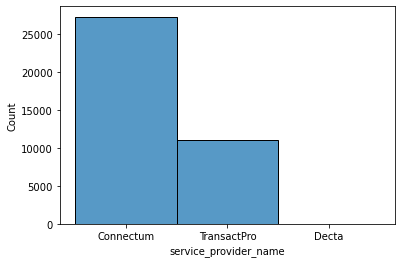

In [733]:
sns.histplot(data=df, x="service_provider_name")

<AxesSubplot:xlabel='Count', ylabel='action_type'>

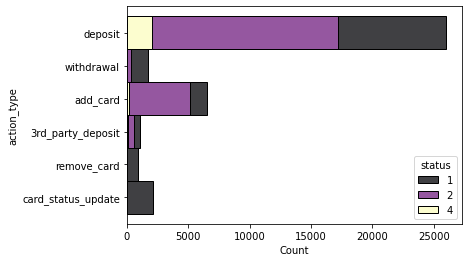

In [734]:
sns.histplot(data=df, y="action_type", hue="status", palette="magma", multiple="stack")

##### **account_number** - уникальный идентификатор клиента

#####  **card_id** - хэшированый номер карты, соответственно, уникальный идентификатор карты
#####  **status:**
- 1 - SUCCESSFULLY_COMPLETED - на стороне банка-эмитента и процессинг-партнера транзакция прошла успешно

- 2 - COMPLETED_WITH_ERRORS - банк-эмитент или процессинг-партнер отказал в транзакции

- 4 - OUTDATED - от процессинг-партнера не был получен ответ по статусу транзакции, считаем транзакцию не успешной

#####  **action_type:**
- deposit - депозит с собственной карты
- withdrawal - вывод на собственную карту
- 3rd_party_deposit - депозит с карты третьего лица
- add_card - привязка собственной карты к счету
- remove_card - отвязка карты от счета
- card_status_update - обновление статусы привязанной карты


In [735]:
df.columns

Index(['account_number', 'card_id', 'amount', 'commission', 'currency',
       'cr_date_time', 'up_date_time', 'status', 'sub_account_type_id',
       'action_type', 'execution_code_id', 'workflow_id',
       'service_provider_name'],
      dtype='object')

# <a class="anchor" id="1.5_bullet" style="color:#b20999"> **EDA** </a>
---


In [736]:
df.shape

(38342, 13)

In [737]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3510436 to 3656629
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   account_number         38342 non-null  int64  
 1   card_id                33577 non-null  object 
 2   amount                 34876 non-null  float64
 3   commission             28773 non-null  float64
 4   currency               34888 non-null  object 
 5   cr_date_time           38342 non-null  object 
 6   up_date_time           38342 non-null  object 
 7   status                 38342 non-null  int64  
 8   sub_account_type_id    28775 non-null  float64
 9   action_type            38342 non-null  object 
 10  execution_code_id      38342 non-null  int64  
 11  workflow_id            14437 non-null  float64
 12  service_provider_name  38342 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 4.1+ MB


### <a class="anchor" id="1.5_bullet" style="color:orange"> Date converting </a>
---


In [738]:
df["cr_date_time"] = pd.to_datetime(df["cr_date_time"], format='%d/%m/%Y %H:%M')
df["up_date_time"] = pd.to_datetime(df["up_date_time"], format='%d/%m/%Y %H:%M') 
df[["up_date_time", "cr_date_time"]].info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3510436 to 3656629
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   up_date_time  38342 non-null  datetime64[ns]
 1   cr_date_time  38342 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 898.6 KB


### <a class="anchor" id="1.5_bullet" style="color:orange"> Currency converting (all to USD) </a>
---


In [739]:
df.currency.unique()

array(['USD', 'EUR', 'CHF', nan, 'GBP', 'JPY', 'RUB', 'PLN', 'SEK', 'CAD',
       'NOK', 'CZK'], dtype=object)

<a> https://www.xe.com/currencyconverter/</a>

In [740]:
CURRENCIES_IN_USD = {
    "USD": 1,
    "EUR": 1.1317052,
    "CHF": 1.0912933,
    "GBP": 1.3603224,
    "JPY": 0.0087083516,
    "RUB": 0.012537327,
    "PLN": 0.24938132,
    "SEK": 0.10601456,
    "CAD": 0.78420079,
    "NOK": 0.11110313,
    "CZK": 0.0463485
}



In [741]:
df['amount_in_usd'] = np.zeros(len(df))
df['commission_in_usd'] = np.zeros(len(df))

for cur in CURRENCIES_IN_USD.keys():
    df['amount_in_usd'] += (df['currency'] == cur) * CURRENCIES_IN_USD[cur] * df['amount']
    df['commission_in_usd'] += (df['currency'] == cur) * CURRENCIES_IN_USD[cur] * df['commission']

df = df.drop(columns=["amount", "commission", "currency"])
df.head(10)

,account_number,card_id,cr_date_time,up_date_time,status,sub_account_type_id,action_type,execution_code_id,workflow_id,service_provider_name,amount_in_usd,commission_in_usd
transaction_id,,,,,,,,,,,,
3510436,1348079,NaN,2022-01-15 00:02:00,2022-01-15 00:02:00,2,21.0,deposit,1103,NaN,Connectum,1.030000,0.030000
3510437,1348079,NaN,2022-01-15 00:02:00,2022-01-15 00:02:00,2,21.0,deposit,1103,NaN,Connectum,1.030000,0.030000
3510438,1352538,e426dcb8cefd379e4e112aa8a7bc128a593a5e373829aa...,2022-01-15 00:02:00,2022-01-15 00:03:00,2,21.0,deposit,1102,NaN,Connectum,98.605474,2.410532
3510439,1324132,08ab089275ad53f0c88bb962ecf49494188d93e3524cb3...,2022-01-15 00:02:00,2022-01-15 00:02:00,2,21.0,deposit,1103,NaN,Connectum,23.199957,0.565853
3510441,1352538,e426dcb8cefd379e4e112aa8a7bc128a593a5e373829aa...,2022-01-15 00:05:00,2022-01-15 00:05:00,2,21.0,deposit,1102,NaN,Connectum,99.430000,2.430000
3510442,1334395,a70738de771bf54b217f6736c728920f09d847e45e9b32...,2022-01-15 00:05:00,2022-01-15 00:05:00,1,21.0,withdrawal,999,1846197.0,TransactPro,3.395116,1.788094
3510447,1368099,ff99628b3900b83d5e496bbfada92a64c121613dd08734...,2022-01-15 00:15:00,2022-01-15 00:16:00,1,22.0,deposit,0,1846198.0,TransactPro,500.000000,7.390000
3510462,1366821,ebdfc6799fd8ed2fb5209de4b46223536af2d588efb151...,2022-01-15 00:40:00,2022-01-15 00:40:00,1,21.0,withdrawal,0,1846201.0,Connectum,54.564665,3.088360
3510469,1368275,50e6f6cdc383befa27af2c890bedbebd3f6e10908e4952...,2022-01-15 00:48:00,2022-01-15 00:51:00,1,21.0,deposit,999,1846205.0,Connectum,1.030000,0.030000


NUMBER OF NULL VALUES PER COLUMN:


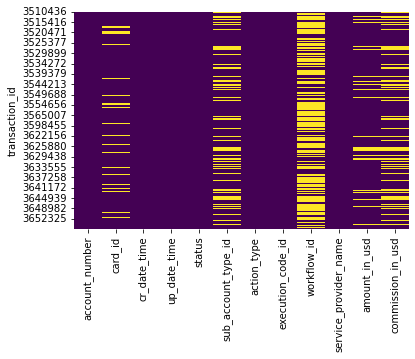

account_number               0
card_id                   4765
cr_date_time                 0
up_date_time                 0
status                       0
sub_account_type_id       9567
action_type                  0
execution_code_id            0
workflow_id              23905
service_provider_name        0
amount_in_usd             3466
commission_in_usd         9569
dtype: int64


In [742]:
print("\033[4mNUMBER OF NULL VALUES PER COLUMN:\033[0m")

sns.heatmap(df.isnull(),cbar=False,cmap='viridis')
plt.show()
print(df.isnull().sum())
cols_with_nan = df.columns[df.isna().any()].tolist()


### <a class="anchor" id="1.5_bullet" style="color:orange"> Dropping useless feature *workflow_id*</a>
---


In [743]:
df = df.drop(columns=["workflow_id"])

# <a class="anchor" id="1.5_bullet" style="color:#b20999"> **FEATURE ENGINEERING** </a>
---


## Lets split our dataframe into smaller datasets by **action type**

In [744]:
def add_feature_per_account_number(df, new_feature_df):
    df = df.merge(new_feature_df,
             on="account_number", how="left")
    df[df.columns[-1]].fillna(0, inplace=True)
    return df
    


## <a class="anchor" id="1.5_bullet" style="color:#b14404"> Deposits </a>
---

#####  **status:**
- 1 - SUCCESSFULLY_COMPLETED - на стороне банка-эмитента и процессинг-партнера транзакция прошла успешно

- 2 - COMPLETED_WITH_ERRORS - банк-эмитент или процессинг-партнер отказал в транзакции

- 4 - OUTDATED - от процессинг-партнера не был получен ответ по статусу транзакции, считаем транзакцию не успешной

In [745]:
df_deposits = df[(df.action_type == "deposit") | (df.action_type == "3rd_party_deposit")]


<AxesSubplot:xlabel='Count', ylabel='action_type'>

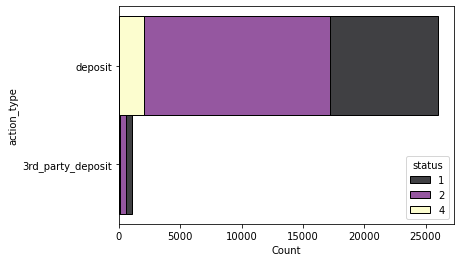

In [746]:
sns.histplot(data=df_deposits, y="action_type", hue="status", palette="magma", multiple="stack")

In [747]:
print(df_deposits.isnull().sum())

account_number              0
card_id                  4765
cr_date_time                0
up_date_time                0
status                      0
sub_account_type_id         0
action_type                 0
execution_code_id           0
service_provider_name       0
amount_in_usd               0
commission_in_usd           2
dtype: int64


### <a class="anchor" id="1.5_bullet" style="color:orange"> Dealing with NaN's in *commissions* </a>
---


In [748]:
df_deposits[df_deposits.commission_in_usd.isnull()]

,account_number,card_id,cr_date_time,up_date_time,status,sub_account_type_id,action_type,execution_code_id,service_provider_name,amount_in_usd,commission_in_usd
transaction_id,,,,,,,,,,,
3528292,1369692,NaN,2022-01-21 20:16:00,2022-01-21 20:16:00,2,21.0,deposit,1106,Connectum,6.258330e+14,NaN
3656388,1351861,NaN,2022-02-15 01:54:00,2022-02-15 01:54:00,2,21.0,deposit,1106,Connectum,1.810728e+14,NaN


In [749]:
commission_percentage = (df_deposits.commission_in_usd / df_deposits.amount_in_usd).mean()

In [750]:
commission_percentage

0.02434122103665446

In [751]:
temp = df_deposits.loc[[3528292, 3656388],:]["amount_in_usd"] * commission_percentage

In [752]:
temp

transaction_id
3528292    1.523354e+13
3656388    4.407534e+12
Name: amount_in_usd, dtype: float64

In [753]:
df_deposits["commission_in_usd"].fillna(temp, inplace=True)

C:\Users\DELL\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [754]:
df_deposits[df_deposits.card_id.isnull()]

,account_number,card_id,cr_date_time,up_date_time,status,sub_account_type_id,action_type,execution_code_id,service_provider_name,amount_in_usd,commission_in_usd
transaction_id,,,,,,,,,,,
3510436,1348079,NaN,2022-01-15 00:02:00,2022-01-15 00:02:00,2,21.0,deposit,1103,Connectum,1.030000,0.030000
3510437,1348079,NaN,2022-01-15 00:02:00,2022-01-15 00:02:00,2,21.0,deposit,1103,Connectum,1.030000,0.030000
3510501,1351973,NaN,2022-01-15 01:37:00,2022-01-15 01:37:00,2,21.0,deposit,1103,Connectum,1.165656,0.033951
3510503,1351973,NaN,2022-01-15 01:37:00,2022-01-15 01:37:00,2,21.0,deposit,1103,Connectum,1.165656,0.033951
3510508,1351973,NaN,2022-01-15 01:38:00,2022-01-15 01:39:00,2,21.0,deposit,1103,Connectum,1.165656,0.033951
...,...,...,...,...,...,...,...,...,...,...,...
3656621,1341114,NaN,2022-02-15 06:31:00,2022-02-15 06:31:00,2,21.0,deposit,1103,Connectum,87.424227,2.546337
3656624,1345776,NaN,2022-02-15 06:37:00,2022-02-15 06:37:00,2,21.0,deposit,1103,Connectum,95.583821,2.783995
3656625,1345776,NaN,2022-02-15 06:37:00,2022-02-15 06:37:00,2,21.0,deposit,1103,Connectum,95.583821,2.783995


### <a class="anchor" id="1.5_bullet" style="color:orange"> Adding new feature:
- number of deposites for each account</a>
---


In [755]:
deposits_per_acc = df_deposits[["action_type", "account_number"]]\
                .groupby("account_number").count()\
                .rename(columns={"action_type": "deposits_per_acc"}).reset_index()
deposits_per_acc.head(2)

,account_number,deposits_per_acc
0,1000024,2
1,1000713,5


In [756]:
df = add_feature_by_account_number(df, deposits_per_acc)

### <a class="anchor" id="1.5_bullet" style="color:orange"> Adding new feature:
- overall amount (sum) of deposites for each account </a>
---


In [757]:
amount_of_deposits_per_acc = df_deposits[["amount_in_usd", "account_number"]]\
                .groupby("account_number").sum()\
                .rename(columns={"amount_in_usd": "amount_of_deposits_per_acc"}).reset_index()

In [758]:
df = add_feature_by_account_number(df, amount_of_deposits_per_acc)

In [759]:
df

,account_number,card_id,cr_date_time,up_date_time,status,sub_account_type_id,action_type,execution_code_id,service_provider_name,amount_in_usd,commission_in_usd,deposits_per_acc,amount_of_deposits_per_acc
0,1348079,NaN,2022-01-15 00:02:00,2022-01-15 00:02:00,2,21.0,deposit,1103,Connectum,1.030000,0.030000,23.0,596.479195
1,1348079,NaN,2022-01-15 00:02:00,2022-01-15 00:02:00,2,21.0,deposit,1103,Connectum,1.030000,0.030000,23.0,596.479195
2,1352538,e426dcb8cefd379e4e112aa8a7bc128a593a5e373829aa...,2022-01-15 00:02:00,2022-01-15 00:03:00,2,21.0,deposit,1102,Connectum,98.605474,2.410532,5.0,496.325474
3,1324132,08ab089275ad53f0c88bb962ecf49494188d93e3524cb3...,2022-01-15 00:02:00,2022-01-15 00:02:00,2,21.0,deposit,1103,Connectum,23.199957,0.565853,7.0,353.804997
4,1352538,e426dcb8cefd379e4e112aa8a7bc128a593a5e373829aa...,2022-01-15 00:05:00,2022-01-15 00:05:00,2,21.0,deposit,1102,Connectum,99.430000,2.430000,5.0,496.325474
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38337,1345776,NaN,2022-02-15 06:37:00,2022-02-15 06:37:00,2,21.0,deposit,1103,Connectum,95.583821,2.783995,50.0,4824.110879
38338,1345776,NaN,2022-02-15 06:37:00,2022-02-15 06:37:00,2,21.0,deposit,1103,Connectum,95.583821,2.783995,50.0,4824.110879
38339,1373280,6c92231e41d18abba1c9d107ece2b0e87cf9a0c73c324a...,2022-02-15 06:37:00,2022-02-15 06:38:00,2,21.0,deposit,299,TransactPro,97.380000,2.380000,1.0,97.380000
38340,1345776,NaN,2022-02-15 06:37:00,2022-02-15 06:37:00,2,21.0,deposit,1103,Connectum,95.583821,2.783995,50.0,4824.110879



## <a class="anchor" id="1.5_bullet" style="color:#b14404"> Withdrawals </a>
---

In [760]:
df_withdrawals = df[(df.action_type == "withdrawal")]

In [761]:
print(df_withdrawals.isnull().sum())

account_number                0
card_id                       0
cr_date_time                  0
up_date_time                  0
status                        0
sub_account_type_id           0
action_type                   0
execution_code_id             0
service_provider_name         0
amount_in_usd                 0
commission_in_usd             0
deposits_per_acc              0
amount_of_deposits_per_acc    0
dtype: int64


<AxesSubplot:xlabel='Count', ylabel='action_type'>

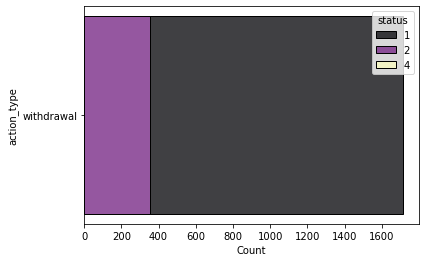

In [762]:
sns.histplot(data=df_withdrawals, y="action_type", hue="status", palette="magma", multiple="stack")

In [763]:
df_withdrawals.describe()

,account_number,status,sub_account_type_id,execution_code_id,amount_in_usd,commission_in_usd,deposits_per_acc,amount_of_deposits_per_acc
count,1.713000e+03,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1.713000e+03
mean,1.311923e+06,1.208990,18.839463,607.374197,415.625865,12.126919,3.529480,1.461373e+12
std,8.907491e+04,0.410992,6.879421,505.059548,632.108427,15.852647,9.732664,3.021544e+13
min,1.000701e+06,1.000000,2.000000,0.000000,0.300000,0.000000,0.000000,0.000000e+00
25%,1.308106e+06,1.000000,21.000000,0.000000,42.000000,2.770000,0.000000,0.000000e+00
50%,1.346731e+06,1.000000,21.000000,999.000000,181.072832,6.224379,0.000000,0.000000e+00
75%,1.363379e+06,1.000000,21.000000,999.000000,577.169652,16.126799,3.000000,1.463399e+02
max,1.373096e+06,4.000000,41.000000,2116.000000,11317.052000,284.623858,119.000000,6.258330e+14


In [764]:
df_withdrawals.head(3)

,account_number,card_id,cr_date_time,up_date_time,status,sub_account_type_id,action_type,execution_code_id,service_provider_name,amount_in_usd,commission_in_usd,deposits_per_acc,amount_of_deposits_per_acc
5,1334395,a70738de771bf54b217f6736c728920f09d847e45e9b32...,2022-01-15 00:05:00,2022-01-15 00:05:00,1,21.0,withdrawal,999,TransactPro,3.395116,1.788094,2.0,22.973616
7,1366821,ebdfc6799fd8ed2fb5209de4b46223536af2d588efb151...,2022-01-15 00:40:00,2022-01-15 00:40:00,1,21.0,withdrawal,0,Connectum,54.564665,3.088360,1.0,1.124032
46,1331397,5c1f77e4cb13947e543de2eddc23aa3de5f44852d87cbd...,2022-01-15 04:02:00,2022-01-15 04:02:00,1,21.0,withdrawal,0,Connectum,540.190183,15.289019,0.0,0.000000


### <a class="anchor" id="1.5_bullet" style="color:orange"> Adding new feature:
- number of withdrawals for each account</a>
---


In [765]:
withdrawals_per_acc = df_withdrawals[["action_type", "account_number"]]\
                .groupby("account_number").count()\
                .rename(columns={"action_type": "withdrawals_per_acc"}).reset_index()
withdrawals_per_acc.head(2)

,account_number,withdrawals_per_acc
0,1000701,4
1,1003276,1


In [766]:
df = add_feature_by_account_number(df, withdrawals_per_acc)

### <a class="anchor" id="1.5_bullet" style="color:orange"> Adding new feature:
- overall amount (sum) of withdrawals for each account</a>
---


In [767]:
amount_of_withdrawals_per_acc = df_withdrawals[["amount_in_usd", "account_number"]]\
                .groupby("account_number").sum()\
                .rename(columns={"amount_in_usd": "amount_of_withdrawals_per_acc"}).reset_index()



In [768]:
amount_of_withdrawals_per_acc.sort_values(by="amount_of_withdrawals_per_acc").tail()

,account_number,amount_of_withdrawals_per_acc
275,1329176,15278.020200
483,1357502,15714.623520
106,1225555,16781.896906
283,1330266,17438.866934
424,1354256,29760.659584


In [769]:
df = add_feature_by_account_number(df, amount_of_withdrawals_per_acc)

## <a class="anchor" id="1.5_bullet" style="color:#b14404"> Card info CRUD operations </a>
---


In [770]:
df_card_info = df[(df.action_type == "add_card")\
                  | (df.action_type == "remove_card")\
                  | (df.action_type == "card_status_update")].drop(columns=[
                                                                "sub_account_type_id",
                                                                "commission_in_usd",
                                                                "amount_in_usd",
                                                                ])


### <a class="anchor" id="1.5_bullet" style="color:orange"> Adding new feature:
- number of cards that were added to each account</a>
---


In [771]:
added_cards = df_card_info[(df_card_info.action_type == "add_card")][["action_type", "account_number"]]\
                .groupby("account_number").count()\
                .rename(columns={"action_type": "num_of_added_cards"}).reset_index()

added_cards.head(2)

,account_number,num_of_added_cards
0,1000701,1
1,1003494,1


In [772]:
df = add_feature_by_account_number(df, added_cards)

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_of_added_cards', ylabel='Density'>

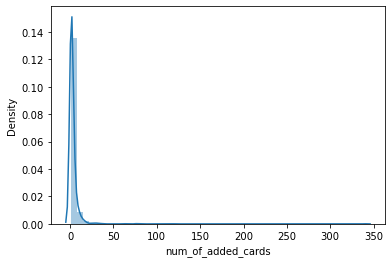

In [773]:
sns.distplot(added_cards["num_of_added_cards"])

In [774]:
added_cards.quantile(0.9)

account_number        1371556.8
num_of_added_cards          6.0
Name: 0.9, dtype: float64

In [775]:
added_cards.describe()

,account_number,num_of_added_cards
count,2.054000e+03,2054.000000
mean,1.339411e+06,3.185005
std,6.723412e+04,9.185900
min,1.000701e+06,1.000000
25%,1.343595e+06,1.000000
50%,1.361213e+06,1.000000
75%,1.369415e+06,3.000000
max,2.089221e+06,340.000000


### <a class="anchor" id="1.5_bullet" style="color:orange"> Adding new feature:
- number of cards that were removed from each account</a>
---


In [776]:
removed_cards = df_card_info[(df_card_info.action_type == "remove_card")][["action_type", "account_number"]]\
                .groupby("account_number").count()\
                .rename(columns={"action_type": "num_of_removed_cards"}).reset_index()
removed_cards.head(2)

,account_number,num_of_removed_cards
0,1007399,1
1,1011042,1


In [777]:
df = add_feature_by_account_number(df, removed_cards)

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_of_removed_cards', ylabel='Density'>

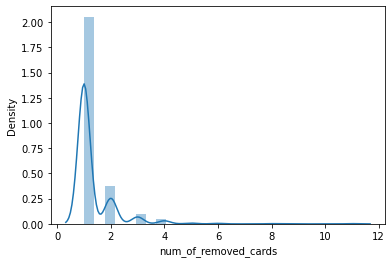

In [778]:
sns.distplot(removed_cards["num_of_removed_cards"])

In [779]:
removed_cards.describe()

,account_number,num_of_removed_cards
count,6.930000e+02,693.000000
mean,1.313848e+06,1.330447
std,8.378922e+04,0.839184
min,1.007399e+06,1.000000
25%,1.303784e+06,1.000000
50%,1.346928e+06,1.000000
75%,1.363069e+06,1.000000
max,1.373333e+06,11.000000


### <a class="anchor" id="1.5_bullet" style="color:orange"> Adding new feature:
- number of cards that were updated for each account</a>
---


In [780]:
updated_cards = df_card_info[(df_card_info.action_type == "card_status_update")][["action_type", "account_number"]]\
                .groupby("account_number").count()\
                .rename(columns={"action_type": "num_of_updated_cards"}).reset_index()
updated_cards.head(2)

,account_number,num_of_updated_cards
0,1000024,1
1,1000701,1


C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_of_updated_cards', ylabel='Density'>

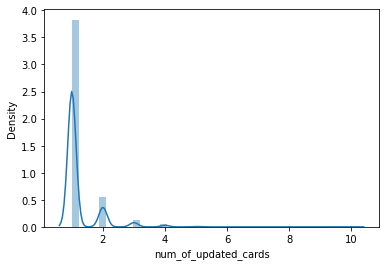

In [781]:
sns.distplot(updated_cards["num_of_updated_cards"])

In [782]:
df = add_feature_by_account_number(df, updated_cards)

### <a class="anchor" id="1.5_bullet" style="color:orange"> Adding new feature:
- Time difference beetween transaction creation and status update time </a>
---


In [783]:
df['up_date_time'] = df['up_date_time'].map(dt.datetime.toordinal)
df['cr_date_time'] = df['cr_date_time'].map(dt.datetime.toordinal)
df['time_difference'] = df['up_date_time'] - df['cr_date_time']

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_difference', ylabel='Density'>

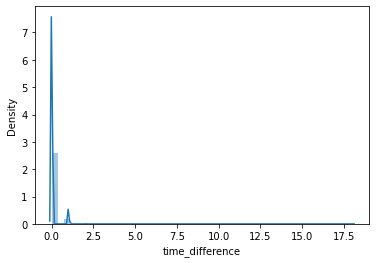

In [784]:
sns.distplot(df['time_difference'])

### <a class="anchor" id="1.5_bullet" style="color:orange"> Droping redundant columns</a>
---


In [785]:
df = df.drop(columns=['account_number', 'card_id', 'cr_date_time', 'up_date_time'])

In [786]:
df = df.set_index(indexes)
df

,status,sub_account_type_id,action_type,execution_code_id,service_provider_name,amount_in_usd,commission_in_usd,deposits_per_acc,amount_of_deposits_per_acc,withdrawals_per_acc,amount_of_withdrawals_per_acc,num_of_added_cards,num_of_removed_cards,num_of_updated_cards,time_difference
3510436,2,21.0,deposit,1103,Connectum,1.030000,0.030000,23.0,596.479195,0.0,0.0,0.0,0.0,0.0,0
3510437,2,21.0,deposit,1103,Connectum,1.030000,0.030000,23.0,596.479195,0.0,0.0,0.0,0.0,0.0,0
3510438,2,21.0,deposit,1102,Connectum,98.605474,2.410532,5.0,496.325474,0.0,0.0,0.0,0.0,1.0,0
3510439,2,21.0,deposit,1103,Connectum,23.199957,0.565853,7.0,353.804997,0.0,0.0,0.0,0.0,0.0,0
3510441,2,21.0,deposit,1102,Connectum,99.430000,2.430000,5.0,496.325474,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656624,2,21.0,deposit,1103,Connectum,95.583821,2.783995,50.0,4824.110879,0.0,0.0,10.0,0.0,0.0,0
3656625,2,21.0,deposit,1103,Connectum,95.583821,2.783995,50.0,4824.110879,0.0,0.0,10.0,0.0,0.0,0
3656626,2,21.0,deposit,299,TransactPro,97.380000,2.380000,1.0,97.380000,0.0,0.0,1.0,0.0,0.0,0
3656628,2,21.0,deposit,1103,Connectum,95.583821,2.783995,50.0,4824.110879,0.0,0.0,10.0,0.0,0.0,0


NUMBER OF NULL VALUES PER COLUMN:


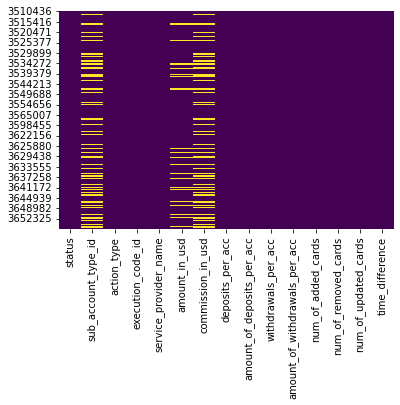

status                              0
sub_account_type_id              9567
action_type                         0
execution_code_id                   0
service_provider_name               0
amount_in_usd                    3466
commission_in_usd                9569
deposits_per_acc                    0
amount_of_deposits_per_acc          0
withdrawals_per_acc                 0
amount_of_withdrawals_per_acc       0
num_of_added_cards                  0
num_of_removed_cards                0
num_of_updated_cards                0
time_difference                     0
dtype: int64


In [787]:
print("\033[4mNUMBER OF NULL VALUES PER COLUMN:\033[0m")

sns.heatmap(df.isnull(),cbar=False,cmap='viridis')
plt.show()
print(df.isnull().sum())
cols_with_nan = df.columns[df.isna().any()].tolist()

In [788]:
cols_with_nan

['sub_account_type_id', 'amount_in_usd', 'commission_in_usd']

### <a class="anchor" id="1.5_bullet" style="color:orange"> One-Hot encoding categorical features </a>
---


In [789]:
for col in df.columns[:5]:
    dummy_na = False
    if col in cols_with_nan:
        dummy_na = True
    dummies = pd.get_dummies(df[col], dummy_na=dummy_na, drop_first=True, prefix=col)
    df = pd.concat([df, dummies], axis=1).drop(columns=[col])

In [790]:
df.head(5)

,amount_in_usd,commission_in_usd,deposits_per_acc,amount_of_deposits_per_acc,withdrawals_per_acc,amount_of_withdrawals_per_acc,num_of_added_cards,num_of_removed_cards,num_of_updated_cards,time_difference,...,execution_code_id_1104,execution_code_id_1105,execution_code_id_1106,execution_code_id_1107,execution_code_id_1108,execution_code_id_1199,execution_code_id_2116,execution_code_id_2121,service_provider_name_Decta,service_provider_name_TransactPro
3510436,1.030000,0.030000,23.0,596.479195,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3510437,1.030000,0.030000,23.0,596.479195,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3510438,98.605474,2.410532,5.0,496.325474,0.0,0.0,0.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
3510439,23.199957,0.565853,7.0,353.804997,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3510441,99.430000,2.430000,5.0,496.325474,0.0,0.0,0.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0


### <a class="anchor" id="1.5_bullet" style="color:orange"> Filling NaN's with 0 </a>
---

#### The point is that some transactions like *add_card* or *remove_card* action types do not have any money transferring, so this cells are empty now

In [791]:
df = df.fillna(0)

In [792]:
print(df.isnull().sum().sort_values().head(5))

amount_in_usd             0
action_type_withdrawal    0
execution_code_id_206     0
execution_code_id_299     0
execution_code_id_310     0
dtype: int64


# <a class="anchor" id="1.5_bullet" style="color:#b20999"> **MODELING** </a>
---


##### The total number of card transactions using cards issued in SEPA amounted to 100.75 billion in 2019, of which 24.16 million were fraudulent (see Chart 1b).
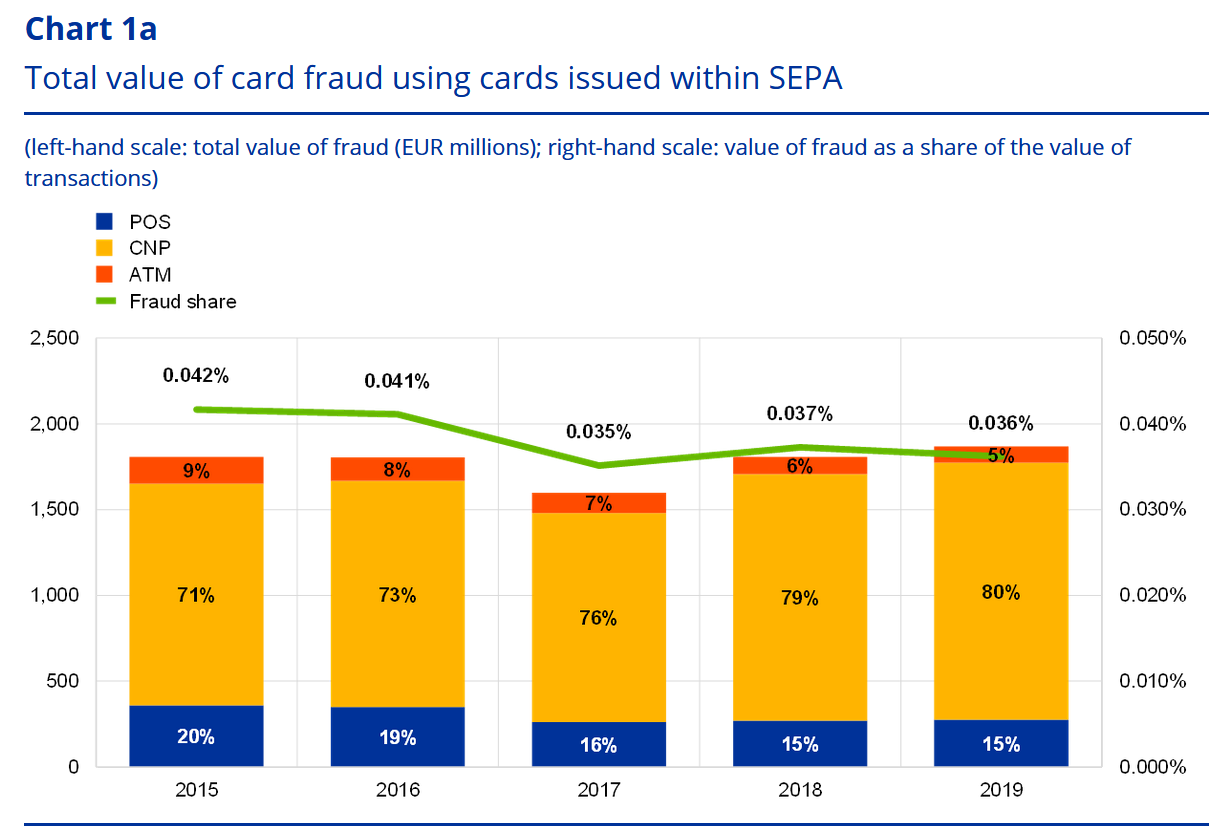
https://www.ecb.europa.eu/pub/cardfraud/html/ecb.cardfraudreport202110~cac4c418e8.en.html

#### **This means that about 0.02398% of transactions are fraudulent.**

## <a class="anchor" id="1.5_bullet" style="color:#b14404"> Isolation Forest model </a>
---


##### Even so only less than 0.5% of all transactions are fraudlent, I will set the *contamination* parameter value to the 0.05 (5%), because we need to optimise **recall**, not **precision** - **we need model to predict all fraud transactions, even if there will be many False Positives**.

In [793]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=5000,n_jobs=-1, contamination=0.05,\
                          random_state=42)

df['isolation_forest_prediction']=iforest.fit_predict(df)

df['isolation_forest_prediction'].replace({1:0,-1:1},inplace=True)

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [794]:
df['isolation_forest_prediction'].value_counts()

0    36424
1     1918
Name: isolation_forest_prediction, dtype: int64

In [795]:
pos = df[df['isolation_forest_prediction'] > 0]
print("\033[4mThe number of transactions that were identified as anomalies by Isolation Forest:\033[0m")

print(pos.shape[0])
print()


The number of transactions that were identified as anomalies by Isolation Forest:
1918



In [796]:
pos.amount_in_usd.value_counts()

0.000000       401
0.100000       376
51.250000       27
5125.000000     27
1091.293300     26
              ... 
7449.907505      1
1127.500000      1
1009.118915      1
38.552281        1
889.404040       1
Name: amount_in_usd, Length: 607, dtype: int64

In [797]:
df.to_csv("processed_df.csv")

In [798]:
results = df["isolation_forest_prediction"].rename("anomaly")

In [799]:
results.to_csv("results.csv")